===========================================

Title: 10.2 Exercises

Author: Chad Wood

Date: 2 Mar 2022

Modified By: Chad Wood

Description: This program demonstrates building several machine learning models; two unsupervised models, two supervised models, and two supervised deep neural network models.

===========================================

In [3]:
import pandas as pd

data_df = pd.read_csv(r'data/hotel-reviews.csv')

### Cleaning Data

In [11]:
# Encodes responses 0='happy'; 1='not happy'
data_df['response_codes'] = data_df['Is_Response'].astype('category').cat.codes

In [90]:
import spacy
import nltk
import re

# Loads spacy and customized stop_words 
nlp = spacy.load('en_core_web_sm')
stop_words = nltk.corpus.stopwords.words('english')
stop_words.remove('no')
stop_words.remove('but')
stop_words.remove('not')

pattern = r'[^a-zA-z\s]'

def normalizer(corpus):
    
    # General Cleansing
    corpus = corpus.apply(lambda x: str(x).lower()) # To Lowercase
    corpus = corpus.apply(lambda x: re.sub(pattern, '', str(x))) # Removes special characters

    # Runs text through pipeline
    nlp_list = []
    for doc in nlp.pipe(corpus, disable=['parser', 'ner', 'textcat']):
        nlp_list.append(' '.join(word.lemma_
                                 if word.lemma_ != '-PRON-' # Preserves pronouns
                                 else word.text for word in doc # Returns roots
                                 if word.lemma_ not in stop_words)) # Filters stopwords

    return pd.Series(nlp_list)

In [91]:
data_df['clean_desc'] = normalizer(data_df.Description) # Normalizes corpus
clean_df = data_df[['response_codes', 'clean_desc']] # New df with only relevant columns
clean_df = clean_df.rename(columns={'response_codes': 'sentiment', 'clean_desc': 'description'}) # Renames

In [141]:
# Equals the amount of data for either review (positive or negative)
# Data is organised randomly
tmp_bad_review_df = clean_df.loc[clean_df.sentiment == 1].sample(n=12411, random_state=1)
tmp_ood_review_df = clean_df.loc[clean_df.sentiment == 0].sample(n=12411, random_state=1)

processed_df = pd.concat([tmp_bad_review_df, 
                          tmp_ood_review_df], 
                         ignore_index=True)

# Combines the fataframes and places combination in random state by row
processed_df = processed_df.sample(frac=1, random_state=1)

print('Random bad Reviews:', tmp_bad_review_df.size)
print('Random Good Reviews:', tmp_ood_review_df.size)
print('Random combined Reviews:', processed_df.size)

Random bad Reviews: 24822
Random Good Reviews: 24822
Random combined Reviews: 49644


### Sentiment Analysis

In [142]:
import numpy as np

# Splits data for supervised model
train, validate, test = np.split(clean_df.sample(frac=1, random_state=42), # Shuffles data
                                 [int(.6*len(clean_df)), int(.8*len(clean_df))]) # Splits 0-60%; 60-80%; 80-100%

##### Unsupervised - TextBlob

In [143]:
import textblob
from lib import model_evaluation_utils as meu

# Runs model
sentiment_polarity = [textblob.TextBlob(description).sentiment.polarity for description in test.description]
# Flips predicted sentiments (i.e., [x>0]=0 and [x<0]=1); Moves neutral to 0.1
predicted_sentiments = [0 if score >= 0.1 else 1 for score in sentiment_polarity]

# Displays results
meu.display_model_performance_metrics(true_labels=test.sentiment, 
                                      predicted_labels=predicted_sentiments, 
                                      classes=[0, 1])

Model Performance metrics:
------------------------------
Accuracy: 0.8013
Precision: 0.8022
Recall: 0.8013
F1 Score: 0.7871

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.80      0.94      0.86      5254
           1       0.81      0.51      0.63      2533

    accuracy                           0.80      7787
   macro avg       0.80      0.73      0.75      7787
weighted avg       0.80      0.80      0.79      7787


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   0     1
Actual: 0       4945   309
        1       1238  1295


##### Unsupervised - AFINN

In [144]:
from afinn import Afinn 

afn = Afinn(emoticons=True)

# Runs model
sentiment_polarity = [afn.score(description) for description in test.description]
# Flips predicted sentiments (i.e., [x>0]=0 and [x<0]=1)
predicted_sentiments = [0 if score >= 0 else 1 for score in sentiment_polarity]

# Displays results
meu.display_model_performance_metrics(true_labels=test.sentiment, 
                                      predicted_labels=predicted_sentiments, 
                                      classes=[0, 1])

Model Performance metrics:
------------------------------
Accuracy: 0.7537
Precision: 0.7907
Recall: 0.7537
F1 Score: 0.7055

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.74      0.99      0.84      5254
           1       0.90      0.27      0.42      2533

    accuracy                           0.75      7787
   macro avg       0.82      0.63      0.63      7787
weighted avg       0.79      0.75      0.71      7787


Prediction Confusion Matrix:
------------------------------
          Predicted:     
                   0    1
Actual: 0       5178   76
        1       1842  691


##### Supervised- TF-IDF Model

In [145]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Builds BOW features - Train
cv = CountVectorizer(binary=False, min_df=0.0, max_df=1.0, ngram_range=(1,2))
cv_x_features = cv.fit_transform(train.description)

# Build TF-IDF features - Train
tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0, ngram_range=(1,2), sublinear_tf=True)
tv_x_features = tv.fit_transform(train.description)

# Gets features for test
cv_y_features = cv.transform(test.description)
tv_y_features = tv.transform(test.description)

print('BOW Train shape:', cv_x_features.shape,
      'BOW Test shape:', cv_y_features.shape)
print('TFIDF Train shape:', tv_x_features.shape,
      'TFIDF Test shape:', tv_y_features.shape)

BOW Train shape: (23359, 706827) BOW Test shape: (7787, 706827)
TFIDF Train shape: (23359, 706827) TFIDF Test shape: (7787, 706827)


In [146]:
from sklearn.linear_model import SGDClassifier, LogisticRegression

# Instantiates logistic Regression model
lr = LogisticRegression(penalty='l2', max_iter=100, C=1)
# Instantiates Support Vector Machine model
svm = SGDClassifier(loss='hinge', max_iter=100)

In [147]:
# Logistic Regression model training with the BOW features.
lr_results_bow = meu.train_predict_model(classifier=lr,
                                         train_features=cv_x_features,
                                         train_labels=train.sentiment,
                                         test_features=cv_y_features, 
                                         test_labels=test.sentiment)

C:\Users\mrcha\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [148]:
# Prints a summary report
meu.display_model_performance_metrics(true_labels=test.sentiment,
                                      predicted_labels=lr_results_bow,
                                      classes=[0, 1])

Model Performance metrics:
------------------------------
Accuracy: 0.8853
Precision: 0.8841
Recall: 0.8853
F1 Score: 0.884

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.90      0.93      0.92      5254
           1       0.85      0.78      0.82      2533

    accuracy                           0.89      7787
   macro avg       0.88      0.86      0.87      7787
weighted avg       0.88      0.89      0.88      7787


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   0     1
Actual: 0       4911   343
        1        550  1983


In [149]:
# Logistic Regression model training with the TF-IDF features.
lr_results_tfidf = meu.train_predict_model(classifier=lr,
                                           train_features=tv_x_features, 
                                           train_labels=train.sentiment,
                                           test_features=tv_y_features, 
                                           test_labels=test.sentiment)

In [150]:
# Prints a summary report
meu.display_model_performance_metrics(true_labels=test.sentiment,
                                      predicted_labels=lr_results_tfidf,
                                      classes=[0,1])

Model Performance metrics:
------------------------------
Accuracy: 0.8903
Precision: 0.8904
Recall: 0.8903
F1 Score: 0.8877

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      5254
           1       0.89      0.75      0.82      2533

    accuracy                           0.89      7787
   macro avg       0.89      0.86      0.87      7787
weighted avg       0.89      0.89      0.89      7787


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   0     1
Actual: 0       5021   233
        1        621  1912


##### Supervised Deep Learning

In [165]:
# Gensim
import gensim

# Keras
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dropout, Activation, Dense
# from keras.layers.normalization import BatchNormalization

# TensorFlow
from tensorflow.keras.layers import BatchNormalization

# sklearn
from sklearn.preprocessing import LabelEncoder

# Using TensorFlow backend.

In [156]:
tokenizer = nlp.tokenizer

def tokenized(corpus):
    # tokenizes text
    return [nlp.tokenizer(document) for document in corpus]

def array_itter(array_data):
    it = np.nditer(array_data)
    while not it.finished:
        

In [171]:
le = LabelEncoder()
binary_cats = 2 # Representing 0 and 1

# List of tokenized descriptions for training
train_tokens = tokenized(train.description)
# Sentiment for training
y_tr = le.fit_transform(train.sentiment)
y_train = np_utils.to_categorical(y_tr, binary_cats)

# List of tokenized setiments for testing
test_tokens = tokenized(test.description)
# Sentiment for testing
y_ts = le.fit_transform(test.sentiment)
y_test = np_utils.to_categorical(y_ts, binary_cats)

In [183]:
from gensim.models import Word2Vec

# Number of features to be used
w2v_num_features = 512 

# build word2vec model
model = Word2Vec()
vocab = model.build_vocab(train_tokens)
w2v_model = gensim.models.Word2Vec(vocab, 
                                   vector_size=w2v_num_features, 
                                   window=150, min_count=10, 
                                   sample=1e-3)

In [186]:
# Provides averaged word vector representation of each document
def averaged_word2vec_vectorizer(corpus, model, num_features):
    vocab = set(model.wv.index_to_key)
    
    # Get features
    def average_word_vectors(words, model, vocab, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        word_count = 0.
        for word in words:
            if word in vocab:
                word_count = word_count + 1.
                feature_vector = np.add(feature_vector, model[word])
            if word_count:
                feature_vector = np.divide(feature_vector, word_count)
                
            return feature_vector
    
    # Call all documents' features to list
    features = [average_word_vectors(tokenized_doc, model, vocab, num_features) for tokenized_doc in corpus]
    
    return np.array(features)

In [187]:
# Gets averaged word vector train features
avg_wv_train_features = averaged_word2vec_vectorizer(corpus=train_tokens, 
                                                     model=w2v_model, 
                                                     num_features= w2v_num_features)

# Gets averaged word vector test features
avg_wv_test_features = averaged_word2vec_vectorizer(corpus=test_tokens, 
                                                    model=w2v_model, 
                                                    num_features= w2v_num_features)

In [199]:
# Train features using the GloVe model
train_nlp = nlp.pipe(train.description, disable=['parser', 'ner', 'textcat'])
train_glove_features = np.array([description.vector for description in train_nlp])

# Test features using the glove model
test_nlp = nlp.pipe(test.description, disable=['parser', 'ner', 'textcat'])
test_glove_features = np.array([description.vector for description in test_nlp])

In [200]:
print('Train Word2Vec features shape:', avg_wv_train_features.shape,
      'Test Word2Vecfeatures shape:', avg_wv_test_features.shape)
print('Train GloVe features shape:', train_glove_features.shape, 
      'Test GloVe features shape:', test_glove_features.shape)

Train Word2Vec features shape: (23359, 512) Test Word2Vecfeatures shape: (7787, 512)
Train GloVe features shape: (23359, 96) Test GloVe features shape: (7787, 96)


In [201]:
# Constructs model architecture of 512 units (num_input_features)
def construct_deepnn_architecture(num_input_features):
    dnn_model = Sequential()
    dnn_model.add(Dense(512, input_shape=(num_input_features,), kernel_initializer='glorot_uniform'))
    dnn_model.add(BatchNormalization()) # Normalizes 0 to 1
    dnn_model.add(Activation('relu')) # Rectified linear unit
    dnn_model.add(Dropout(0.2)) # Prevents overfitting by seting 20% to 0
    dnn_model.add(Dense(512, kernel_initializer='glorot_uniform'))
    dnn_model.add(BatchNormalization()) # Normalizes 0 to 1
    dnn_model.add(Activation('relu')) # Rectified linear unit
    dnn_model.add(Dropout(0.2))# Prevents overfitting by seting 20% to 0
    dnn_model.add(Dense(512, kernel_initializer='glorot_uniform'))
    dnn_model.add(BatchNormalization()) # Normalizes 0 to 1
    dnn_model.add(Activation('relu')) # Rectified linear unit
    dnn_model.add(Dropout(0.2))# Prevents overfitting by seting 20% to 0
    dnn_model.add(Dense(2))
    dnn_model.add(Activation('softmax')) # Binary logistic regression
    dnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return dnn_model

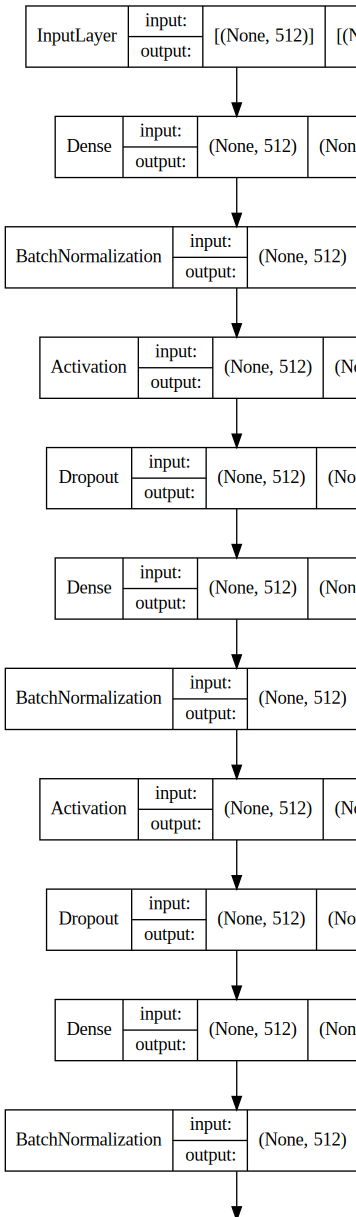

In [203]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# Creates model architecture
w2v_dnn = construct_deepnn_architecture(w2v_num_features)

# Visualizes architecture
SVG(model_to_dot(w2v_dnn, show_shapes=True, show_layer_names=False, rankdir='TB').create(prog='dot', format='svg'))

In [204]:
# Fits the model with data
batch_size = 100
w2v_dnn.fit(avg_wv_train_features, 
            y_train, 
            epochs=10, 
            batch_size=batch_size, 
            shuffle=True, 
            validation_split=0.1, # Notably not using prior split. Will be corrected in future iterations.
            verbose=1)

Epoch 1/10
211/211 [==============================] - 9s 38ms/step - loss: 0.6649 - accuracy: 0.6813 - val_loss: 0.6403 - val_accuracy: 0.6935
Epoch 2/10
211/211 [==============================] - 8s 36ms/step - loss: 0.6355 - accuracy: 0.6813 - val_loss: 0.6226 - val_accuracy: 0.6935
Epoch 3/10
211/211 [==============================] - 8s 37ms/step - loss: 0.6276 - accuracy: 0.6813 - val_loss: 0.6180 - val_accuracy: 0.6935
Epoch 4/10
211/211 [==============================] - 8s 37ms/step - loss: 0.6261 - accuracy: 0.6813 - val_loss: 0.6169 - val_accuracy: 0.6935
Epoch 5/10
211/211 [==============================] - 8s 36ms/step - loss: 0.6259 - accuracy: 0.6813 - val_loss: 0.6167 - val_accuracy: 0.6935
Epoch 6/10
211/211 [==============================] - 7s 36ms/step - loss: 0.6259 - accuracy: 0.6813 - val_loss: 0.6166 - val_accuracy: 0.6935
Epoch 7/10
211/211 [==============================] - 8s 36ms/step - loss: 0.6259 - accuracy: 0.6813 - val_loss: 0.6166 - val_accuracy: 0.6935

In [208]:
# DeepNN Model Architecture
glove_dnn = construct_deepnn_architecture(num_input_features=96)

# Fits the model with data
batch_size = 100
glove_dnn.fit(train_glove_features, 
              y_train, epochs=5, 
              batch_size=batch_size, 
              shuffle=True, 
              validation_split=0.1, 
              verbose=1)

Epoch 1/5
211/211 [==============================] - 7s 29ms/step - loss: 0.5645 - accuracy: 0.7372 - val_loss: 0.5860 - val_accuracy: 0.6982
Epoch 2/5
211/211 [==============================] - 6s 28ms/step - loss: 0.4922 - accuracy: 0.7636 - val_loss: 0.5198 - val_accuracy: 0.7573
Epoch 3/5
211/211 [==============================] - 6s 29ms/step - loss: 0.4723 - accuracy: 0.7745 - val_loss: 0.5006 - val_accuracy: 0.7586
Epoch 4/5
211/211 [==============================] - 6s 28ms/step - loss: 0.4634 - accuracy: 0.7801 - val_loss: 0.4922 - val_accuracy: 0.7607
Epoch 5/5
211/211 [==============================] - 6s 29ms/step - loss: 0.4543 - accuracy: 0.7845 - val_loss: 0.5160 - val_accuracy: 0.7633
